In [30]:
import h5py
from string import Template
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt, cm
#!pip install pyestimate
#from pyestimate import sin_param_estimate

def integrate_q(data,q,q_roi, norm_sum):
    """checked by Christian"""
    q_start, q_stop = q_roi
    start_index = np.where(q>=q_start)[0][0]
    stop_index = np.where(q>=q_stop)[0][0]
    azimutal_integrated = np.sum(data[...,start_index:stop_index]*norm_sum[:,start_index:stop_index] ,axis=(2,3))
    norm = np.sum(norm_sum[:,start_index:stop_index], axis=(0,1))
    output = np.divide(azimutal_integrated ,norm , out=np.zeros_like(azimutal_integrated))
    return output

def load_data(proposal,visit,scan, det, fly_scan, cluster='maxiv'):
    """keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """
    if cluster == 'maxiv':
        fname = '/data/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == 'lunarc':
        fname = '/projects/maxiv/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    else:
        print("Clustername is not recognised")
        
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(fname, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    master = fname.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]

    # fly or step scan
    if fly_scan == True:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    else:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4])+1)
    return data


# Parameters (to be defined by user)

In [31]:
scan = 28
proposal = 20240661
visit = 2024102408
#det = 'eiger' # Pick 'eiger' or 'lambda'
#q_range = (0.0288,0.030) # Select q_range = (q_min,q_max) for q-dependent plot
#q_range = ()

det = 'lambda'
#q_range = (1.59,1.64)
q_range = (1.70,1.80)



In [32]:

fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
fh = h5py.File(fname, 'r')
title_str = str(fh['entry/title'][()]).split(' ')
title_str
title_str[0][2:]

'meshct_maxiv'

NameError: name '__file__' is not defined

# Data processing

In [10]:
def process_data(scan, proposal, visit, det, q_range):
    #Reading scan parameters
    fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
    fh = h5py.File(fname, 'r')
    title_str = str(fh['entry/title'][()]).split(' ')
    
    if title_str[0][2:] == 'meshct_maxiv':
        fly_scan = True
    else:
        fly_scan = False
            
    if title_str[10][0:4] == 'True':
        snake_scan = True
    else:
        snake_scan = False
    
    endtime = fh['entry/end_time'][()]
        
    #Loading data
    data = load_data(proposal,visit,scan,det, fly_scan)
    
    # absorption contrast
    I = data['i_t'].reshape(data['shape'])
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:] = I_flipped[1::2,::-1]
    absorption = I_flipped
    
    
    # dark field
    I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))
    
    I_flipped = np.copy(I)
    if snake_scan == True:
        I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
    data_scat = I_flipped
    total_scattering = np.average(data_scat,axis=(2,3))
    
    q = data['q']
    norm_sum = data['norm']
    
    #Defining q ranges for background subtraction
    q_bg1 = (q_range[0]-(q_range[1]-q_range[0]),q_range[0]) 
    q_bg2 = (q_range[1],q_range[1]+(q_range[1]-q_range[0])) 
    
    ind_q = list(np.where((q>q_range[0]) & (q<q_range[1]))[0])
    ind_bg1 = list(np.where((q>q_bg1[0]) & (q<q_bg1[1]))[0])
    ind_bg2 = list(np.where((q>q_bg2[0]) & (q<q_bg2[1]))[0])
    
    #print(len(ind_q))
    #print(len(ind_bg1))
    #print(len(ind_bg2))
    
    # q dependent, background subtracted
    image = integrate_q(data_scat,q,q_range,norm_sum)  - 0.5*((len(ind_q)/len(ind_bg1))*integrate_q(data_scat,q,q_bg1,norm_sum) + (len(ind_q)/len(ind_bg2))*integrate_q(data_scat,q,q_bg2,norm_sum))

    return absorption, total_scattering, image, endtime


# Plotting

In [65]:
def plot_data(scan, proposal, visit, det, absorption, total_scattering, image, text):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,10))
    # title
    fig.suptitle('Scan %d, Detector: %s\n%s' %(scan, det, text), fontsize=16)
    # tight layout
    # fig.tight_layout()

    # absorption
    ax1.imshow(absorption)
    ax1.title.set_text('Absorption')

    # dark field
    ax2.imshow(total_scattering)
    ax2.title.set_text('Dark field')

    #q dependent
    ax3.imshow(image)
    ax3.title.set_text('q dependent')

    #save figure
    fig.savefig('/data/visitors/formax/%s/%s/process/images/scan_%d_%s.png' %(proposal, visit, scan, det))

In [73]:
folder ='/data/visitors/formax/%s/%s' %(proposal, visit)

scans = list(range(61, 70))
scan_data = []
for scan in scans:
    print('process data for scan %d' %scan)
    try:
        absorption, total_scattering, image, endtime = process_data(scan, proposal, visit, det, q_range)
        scan_data.append([absorption, total_scattering, image, endtime])
    except:
        print('Failed to process scan %d' %scan)
        scan_data.append(None)


process data for scan 61
process data for scan 62
process data for scan 63
process data for scan 64
process data for scan 65
process data for scan 66
process data for scan 67
process data for scan 68
process data for scan 69


In [74]:
import pandas as pd
folder ='/data/visitors/formax/%s/%s' %(proposal, visit)

RH_file = 'process/tensile_and_humidity/RH_increase_long.txt'
headers = ['Elap Time','Set Hum','Read Hum','Wet Flow','Dry Flow','Sensor Temp','Used Temp']
RH_data = pd.read_csv(os.path.join(folder, RH_file), delimiter='\t', skiprows=26, names=headers)
# print(RH_data)
RH_data['Datetime'] = pd.to_datetime(RH_data['Elap Time'])
# change the day for the ones after 20:00:00 to the previous day
RH_data.loc[ RH_data['Datetime'].dt.hour >= 20, 'Datetime'] = RH_data['Datetime'] - pd.Timedelta(days=1)
RH_data

/tmp/ipykernel_43987/209373231.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  RH_data['Datetime'] = pd.to_datetime(RH_data['Elap Time'])


,Elap Time,Set Hum,Read Hum,Wet Flow,Dry Flow,Sensor Temp,Used Temp,Datetime
0,22:40:22,40.0,39.9,1.7,3.3,25.5,25.5,2024-10-24 22:40:22
1,22:40:40,40.0,39.9,1.7,3.3,25.5,25.5,2024-10-24 22:40:40
2,22:45:40,40.0,40.0,1.7,3.3,25.5,25.5,2024-10-24 22:45:40
3,22:50:40,40.0,40.0,1.7,3.3,25.5,25.5,2024-10-24 22:50:40
4,22:55:40,40.0,40.0,1.7,3.3,25.5,25.5,2024-10-24 22:55:40
...,...,...,...,...,...,...,...,...
123,08:50:40,30.0,30.0,1.2,3.8,25.4,25.4,2024-10-25 08:50:40
124,08:55:40,30.0,30.0,1.2,3.8,25.4,25.4,2024-10-25 08:55:40
125,09:00:40,30.0,30.0,1.2,3.8,25.4,25.4,2024-10-25 09:00:40
126,09:05:40,30.0,30.0,1.2,3.8,25.4,25.4,2024-10-25 09:05:40


In [75]:
# correlate RH data with scan data
import datetime
scan_times = [data[3] for data in scan_data]
scan_times = [datetime.datetime.fromisoformat(time.decode('utf-8')) for time in scan_times]
scan_times

temps = []
hums = []
for i, time in enumerate(scan_times):
    print(i, time)
    # find the closest time before in RH_data and interpolate the sensor temp and Read Hum
    idx = RH_data[RH_data['Datetime'] < time].index[-1]
    temps.append(RH_data['Sensor Temp'][idx])
    hums.append(RH_data['Read Hum'][idx])

# add the temperature and humidity to the scan data, and replace the time with the scan_times
for i, data in enumerate(scan_data):
    data.append(temps[i])
    data.append(hums[i])
    data[3] = scan_times[i]


0 2024-10-24 23:09:30.964442
1 2024-10-25 00:09:39.611866
2 2024-10-25 01:09:48.036680
3 2024-10-25 02:09:57.231288
4 2024-10-25 03:10:06.303496
5 2024-10-25 04:10:14.872018
6 2024-10-25 05:10:23.499025
7 2024-10-25 06:10:32.468746
8 2024-10-25 07:10:41.111671


In [76]:
scan_data[0]

[array([[0.00068497, 0.00068824, 0.00068575, ..., 0.00068576, 0.00068481,
         0.00068566],
        [0.0006843 , 0.00068587, 0.00068378, ..., 0.00068507, 0.00068537,
         0.00068667],
        [0.00068494, 0.00068543, 0.00068616, ..., 0.00068406, 0.00068407,
         0.00068423],
        ...,
        [0.00066866, 0.00066883, 0.00066849, ..., 0.00066818, 0.00066755,
         0.00066845],
        [0.00066834, 0.00066784, 0.00066817, ..., 0.00067077, 0.000672  ,
         0.00066839],
        [0.00066866, 0.00066941, 0.00066862, ..., 0.00066803, 0.00066804,
         0.00066755]]),
 array([[7.2508807, 7.2838535, 7.2595134, ..., 7.296345 , 7.2888126,
         7.2970195],
        [7.2640715, 7.2817755, 7.2655463, ..., 7.2930603, 7.295832 ,
         7.305614 ],
        [7.2606034, 7.2710824, 7.282641 , ..., 7.295242 , 7.293866 ,
         7.292938 ],
        ...,
        [7.2407966, 7.247654 , 7.245783 , ..., 7.275568 , 7.26797  ,
         7.27569  ],
        [7.254032 , 7.2475953, 7.257

plotting scan 61
Endtime: 2024-10-24 23:09:30, Temp: 25.5, Hum: 40.0
plotting scan 62
Endtime: 2024-10-25 00:09:39, Temp: 25.5, Hum: 50.0
plotting scan 63
Endtime: 2024-10-25 01:09:48, Temp: 25.5, Hum: 60.0
plotting scan 64
Endtime: 2024-10-25 02:09:57, Temp: 25.5, Hum: 65.0
plotting scan 65
Endtime: 2024-10-25 03:10:06, Temp: 25.5, Hum: 70.0
plotting scan 66
Endtime: 2024-10-25 04:10:14, Temp: 25.5, Hum: 75.0
plotting scan 67
Endtime: 2024-10-25 05:10:23, Temp: 25.5, Hum: 80.0
plotting scan 68
Endtime: 2024-10-25 06:10:32, Temp: 25.5, Hum: 85.0
plotting scan 69
Endtime: 2024-10-25 07:10:41, Temp: 25.5, Hum: 89.0


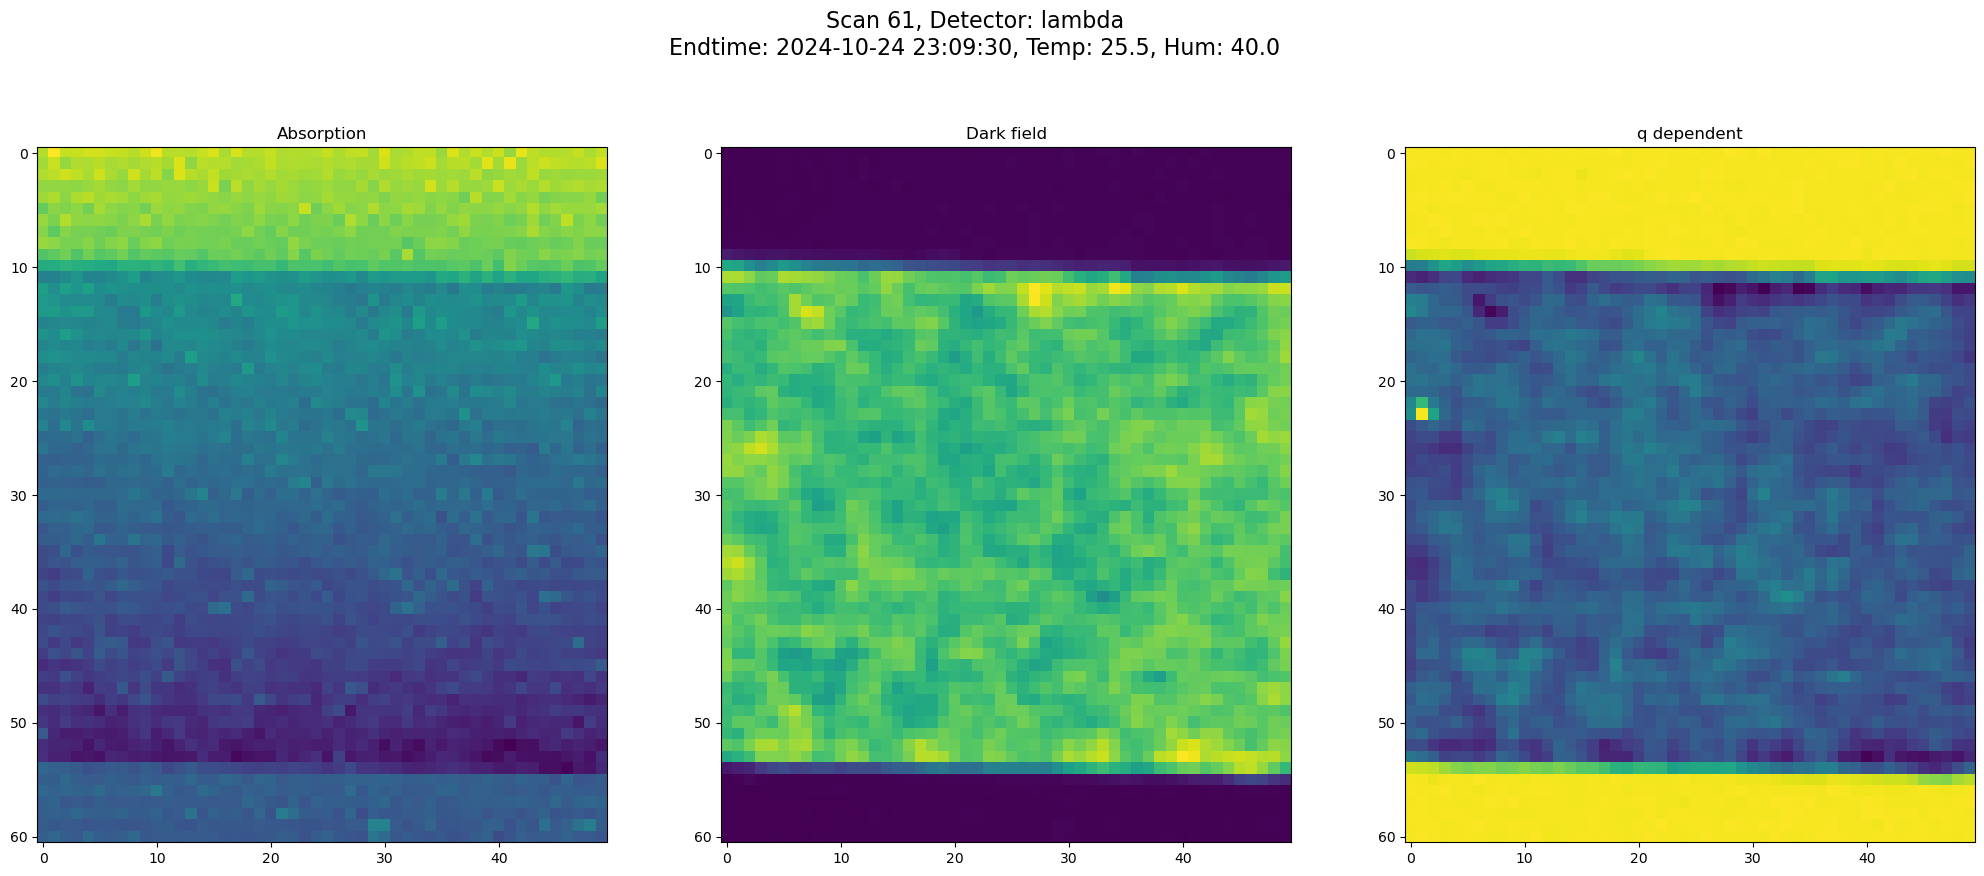

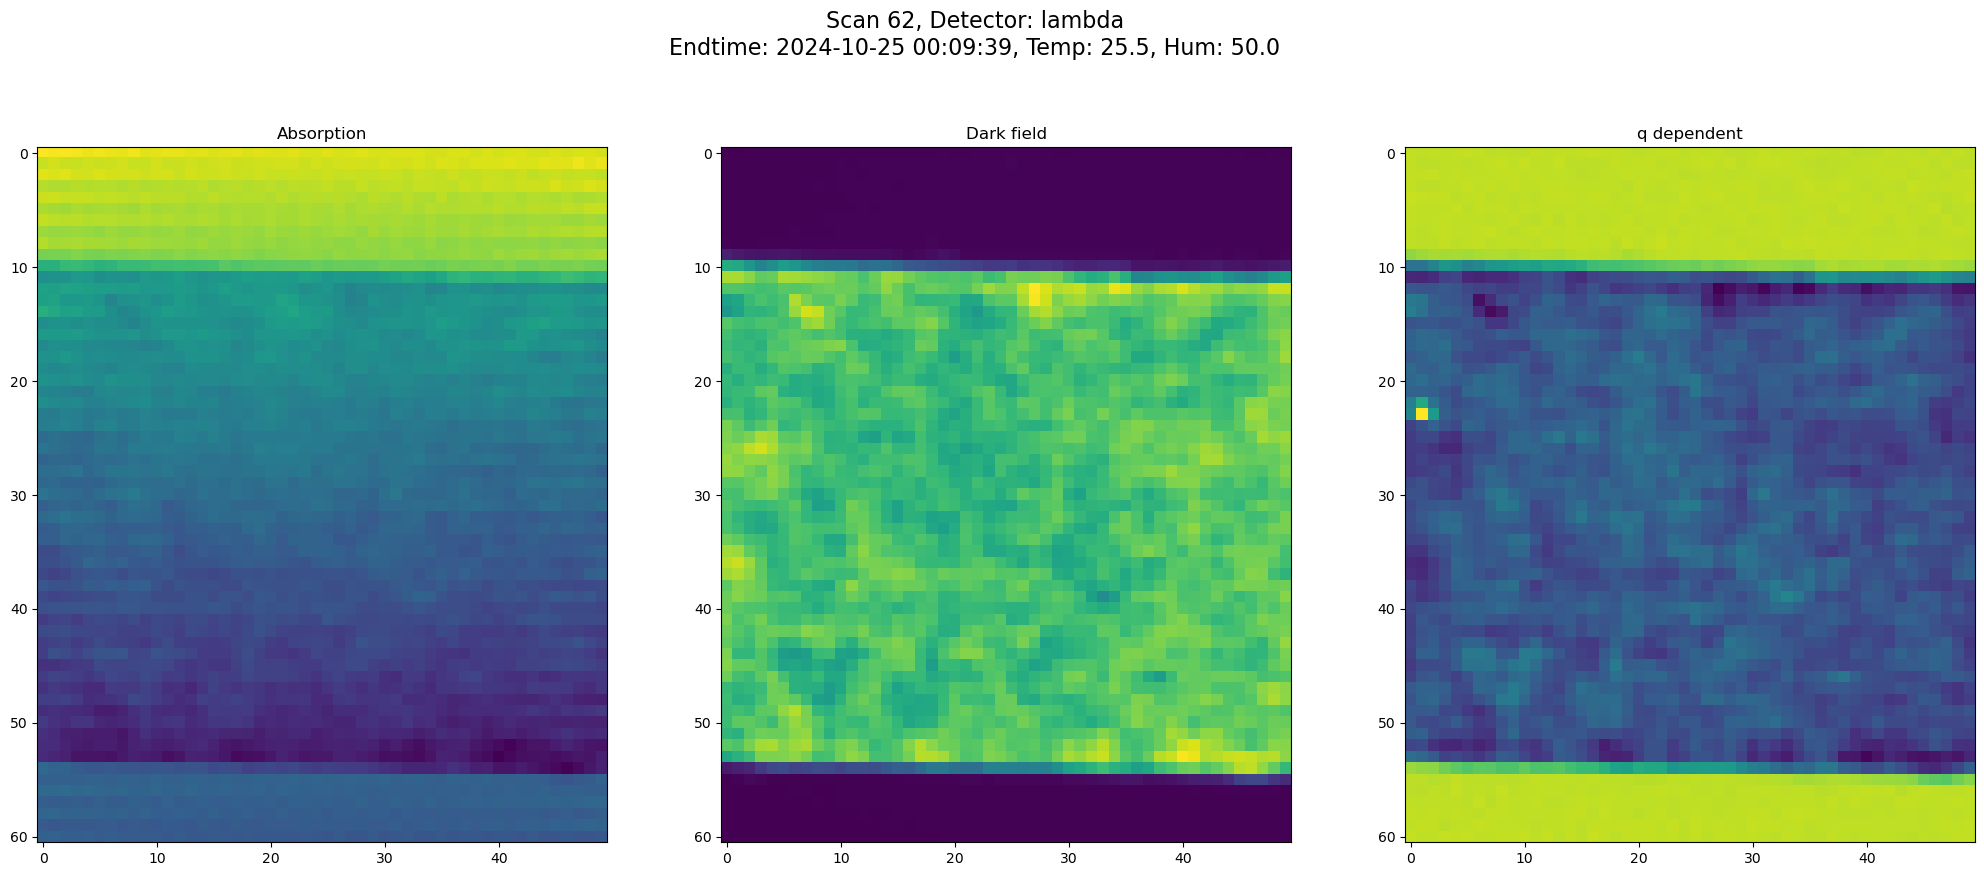

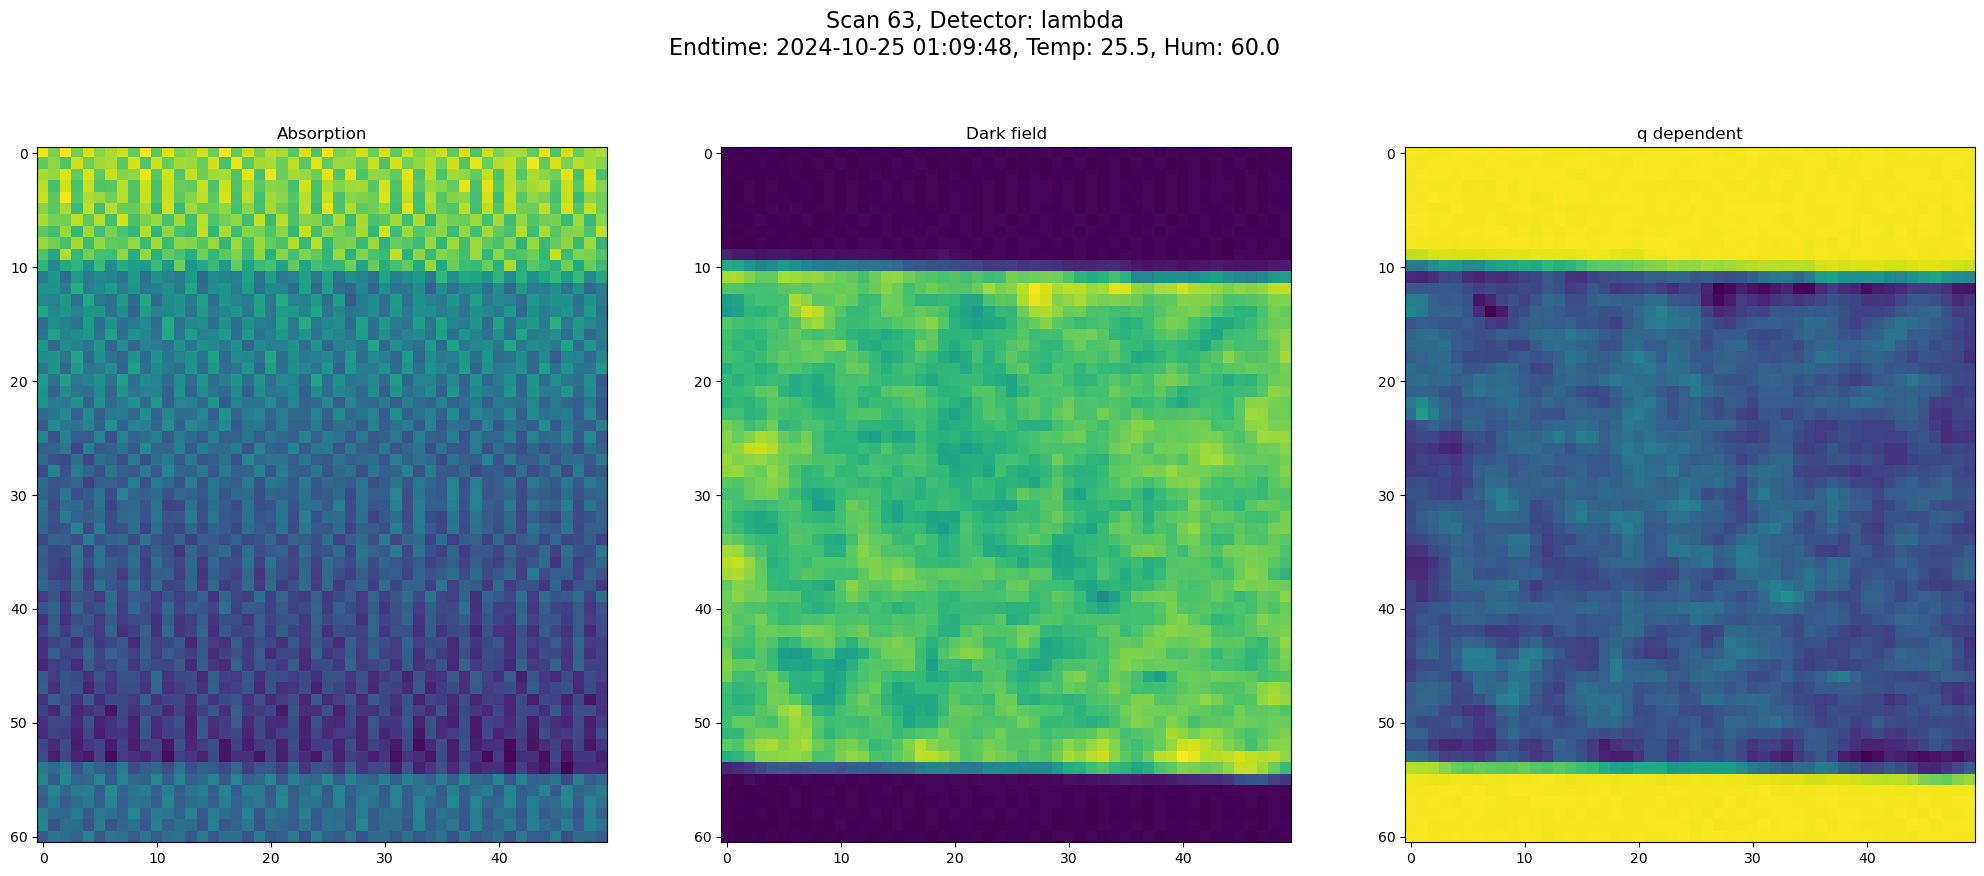

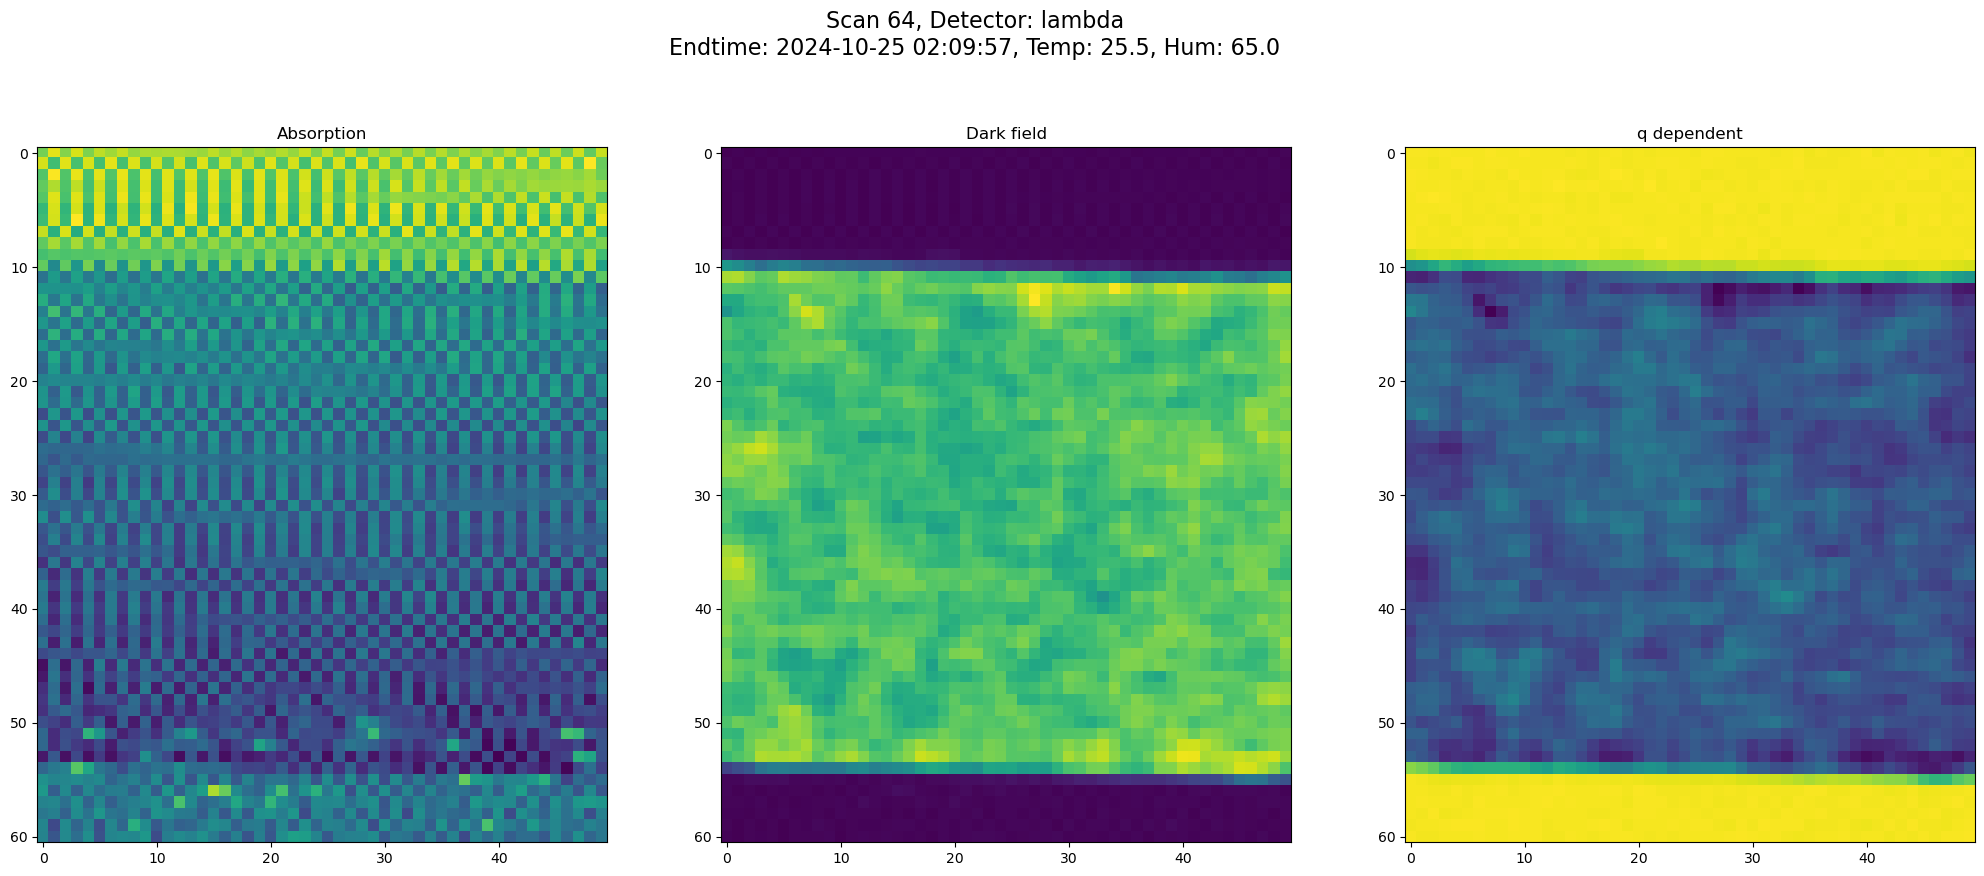

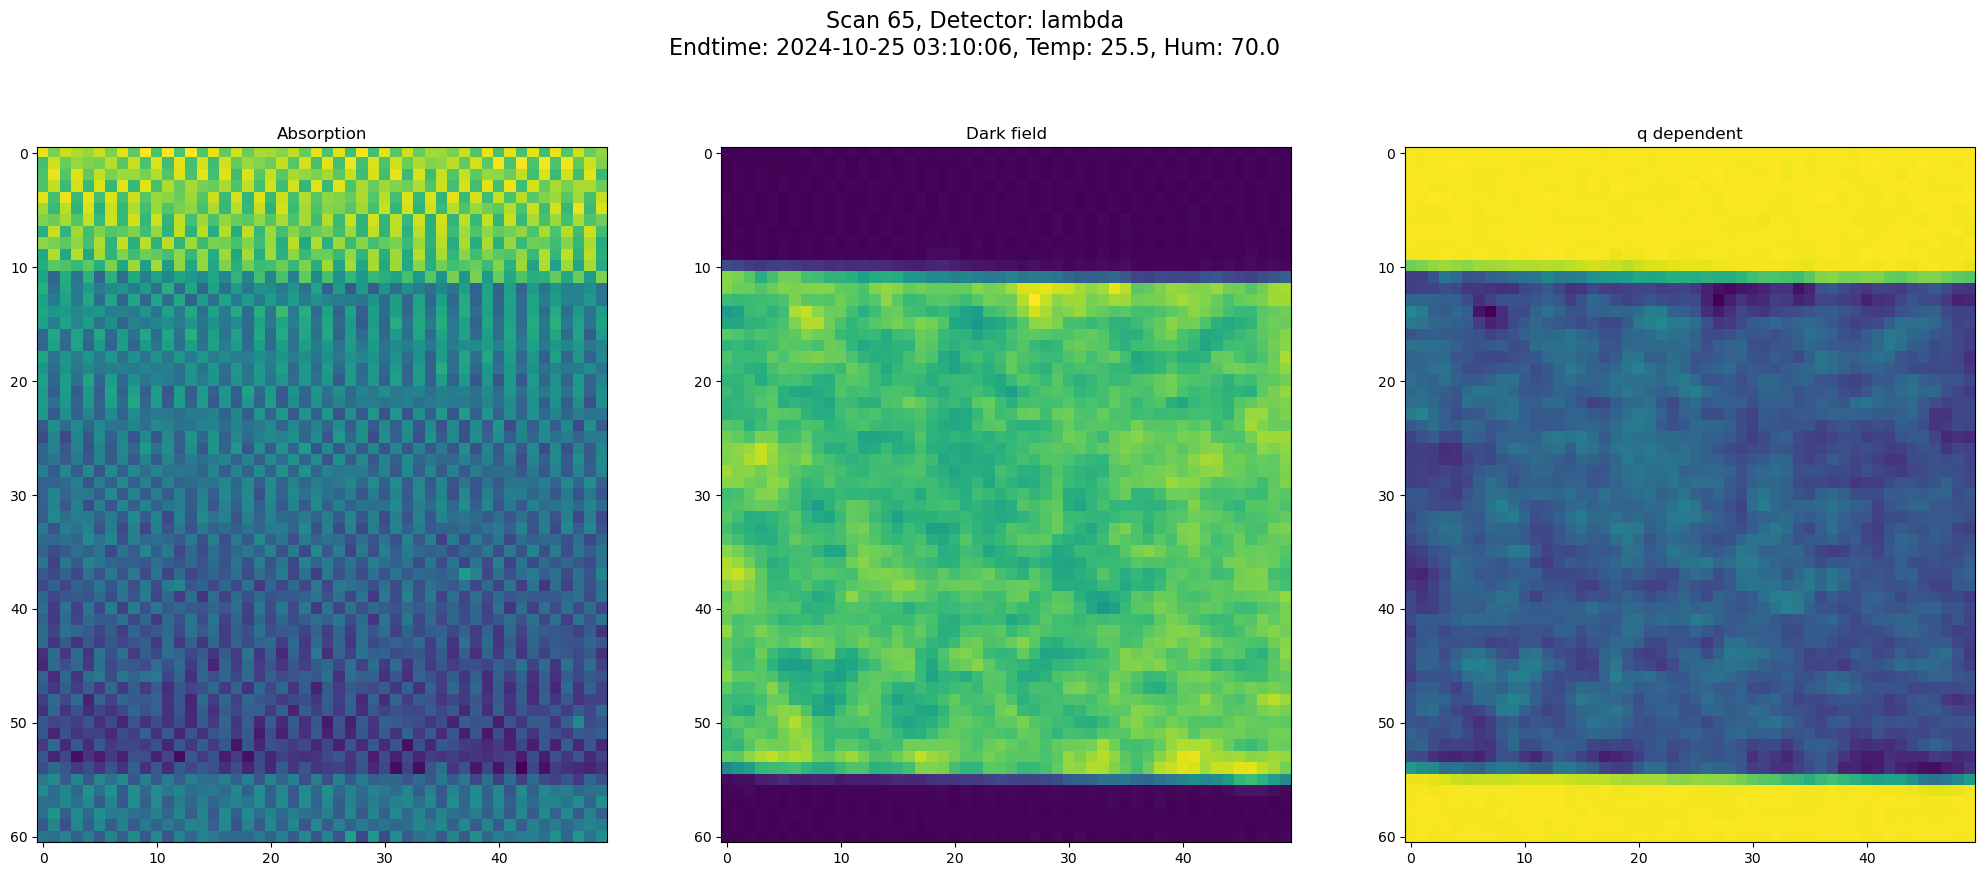

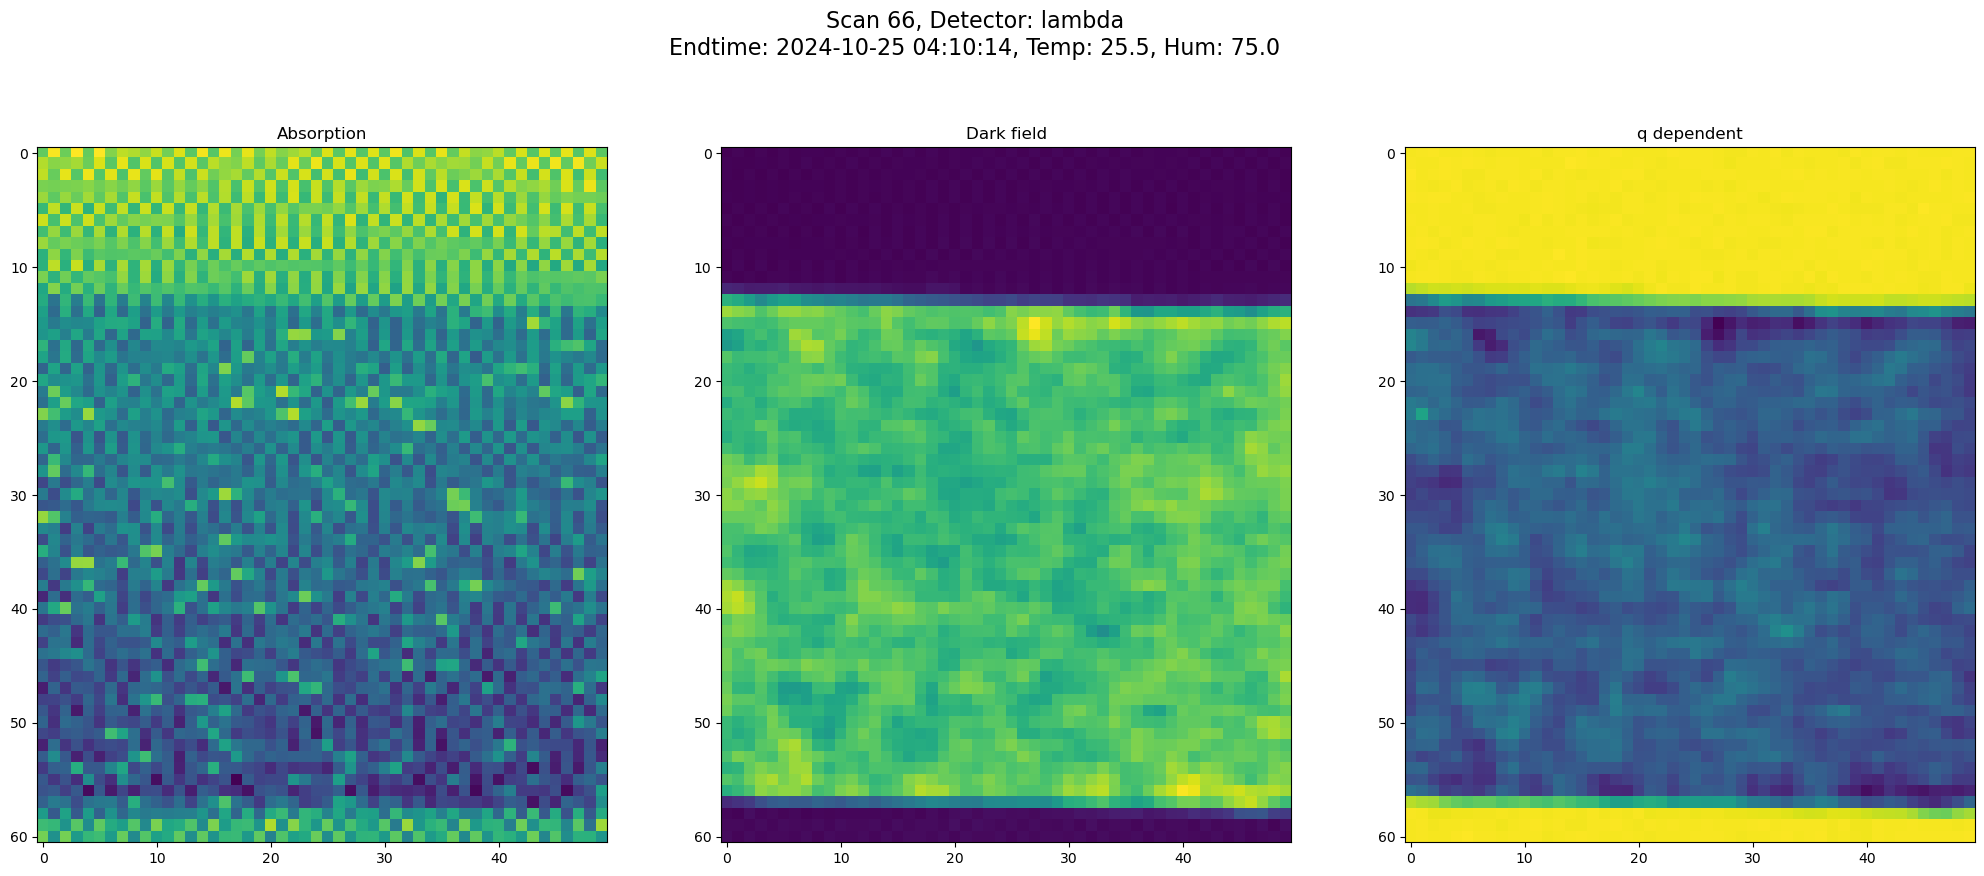

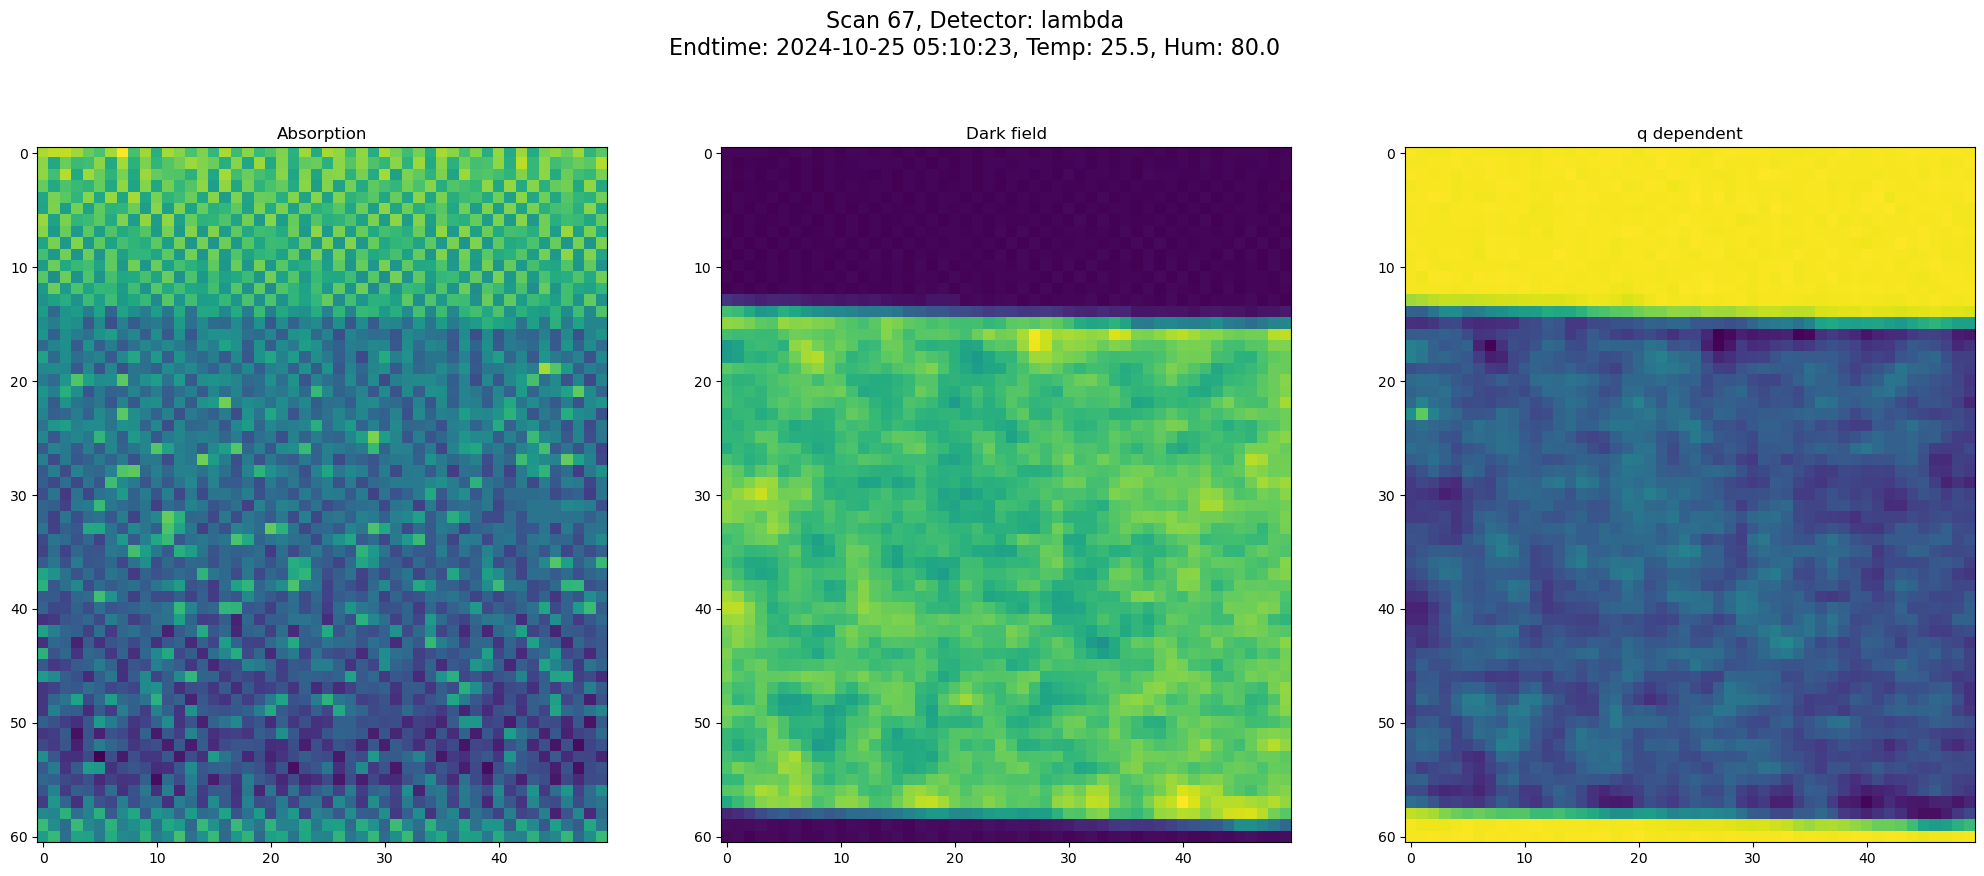

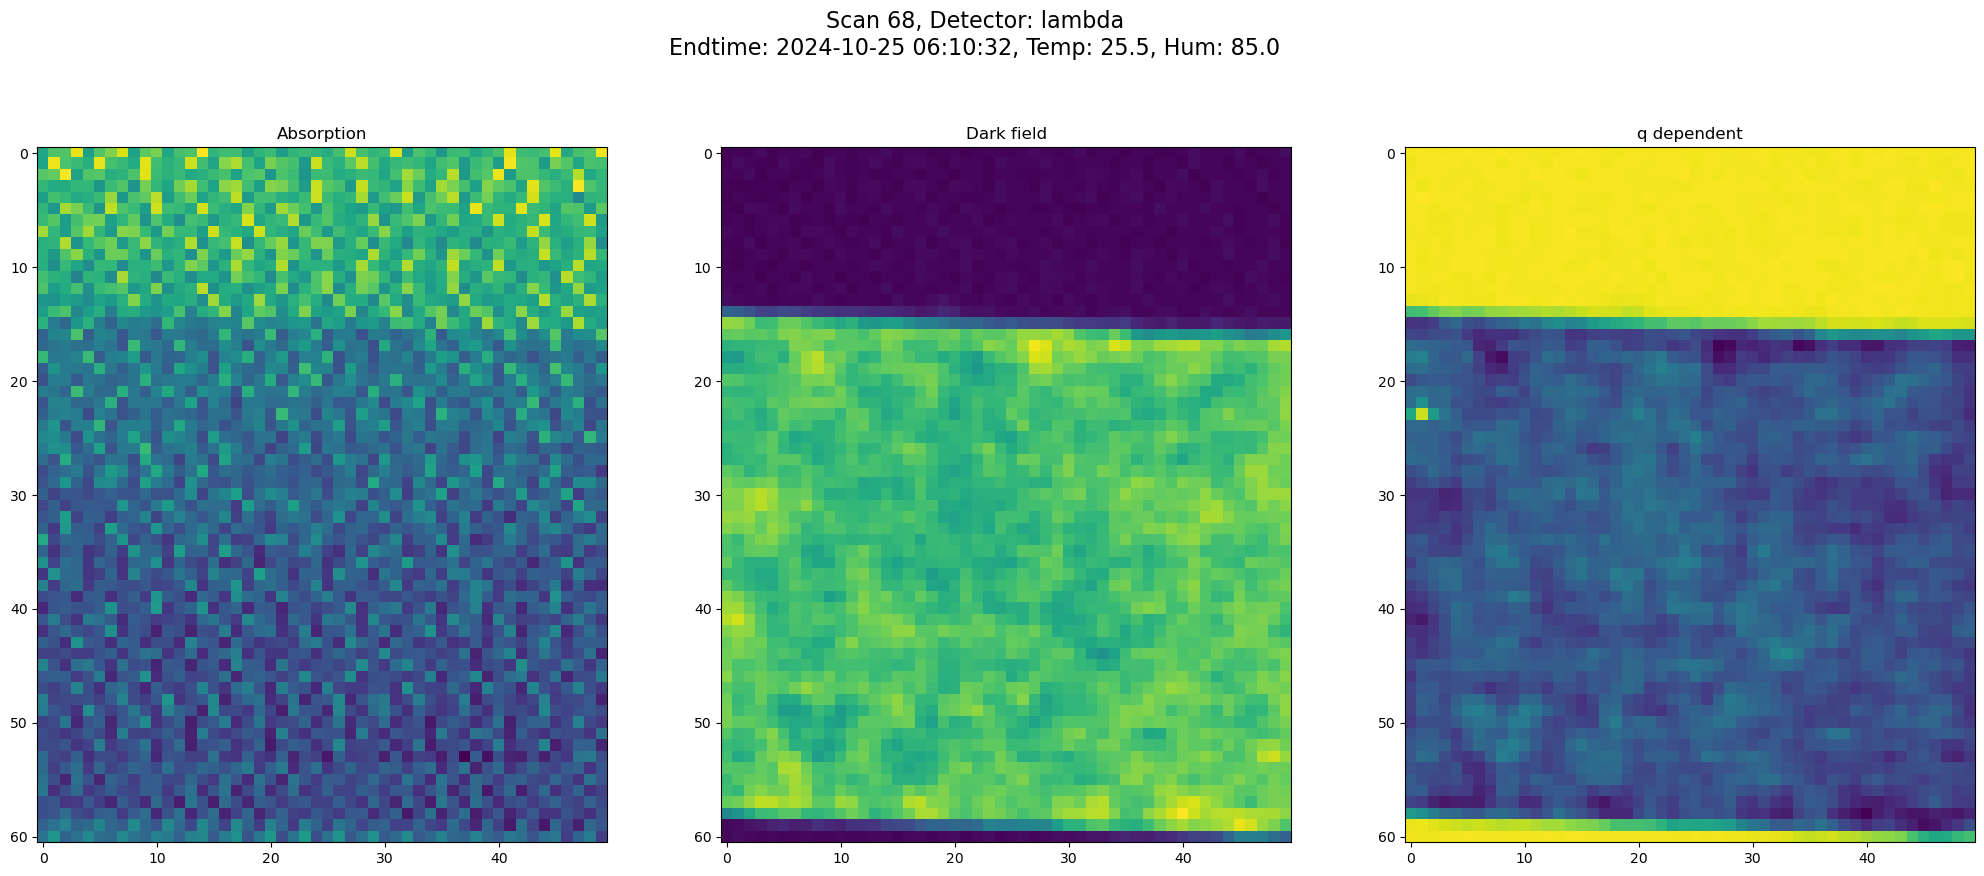

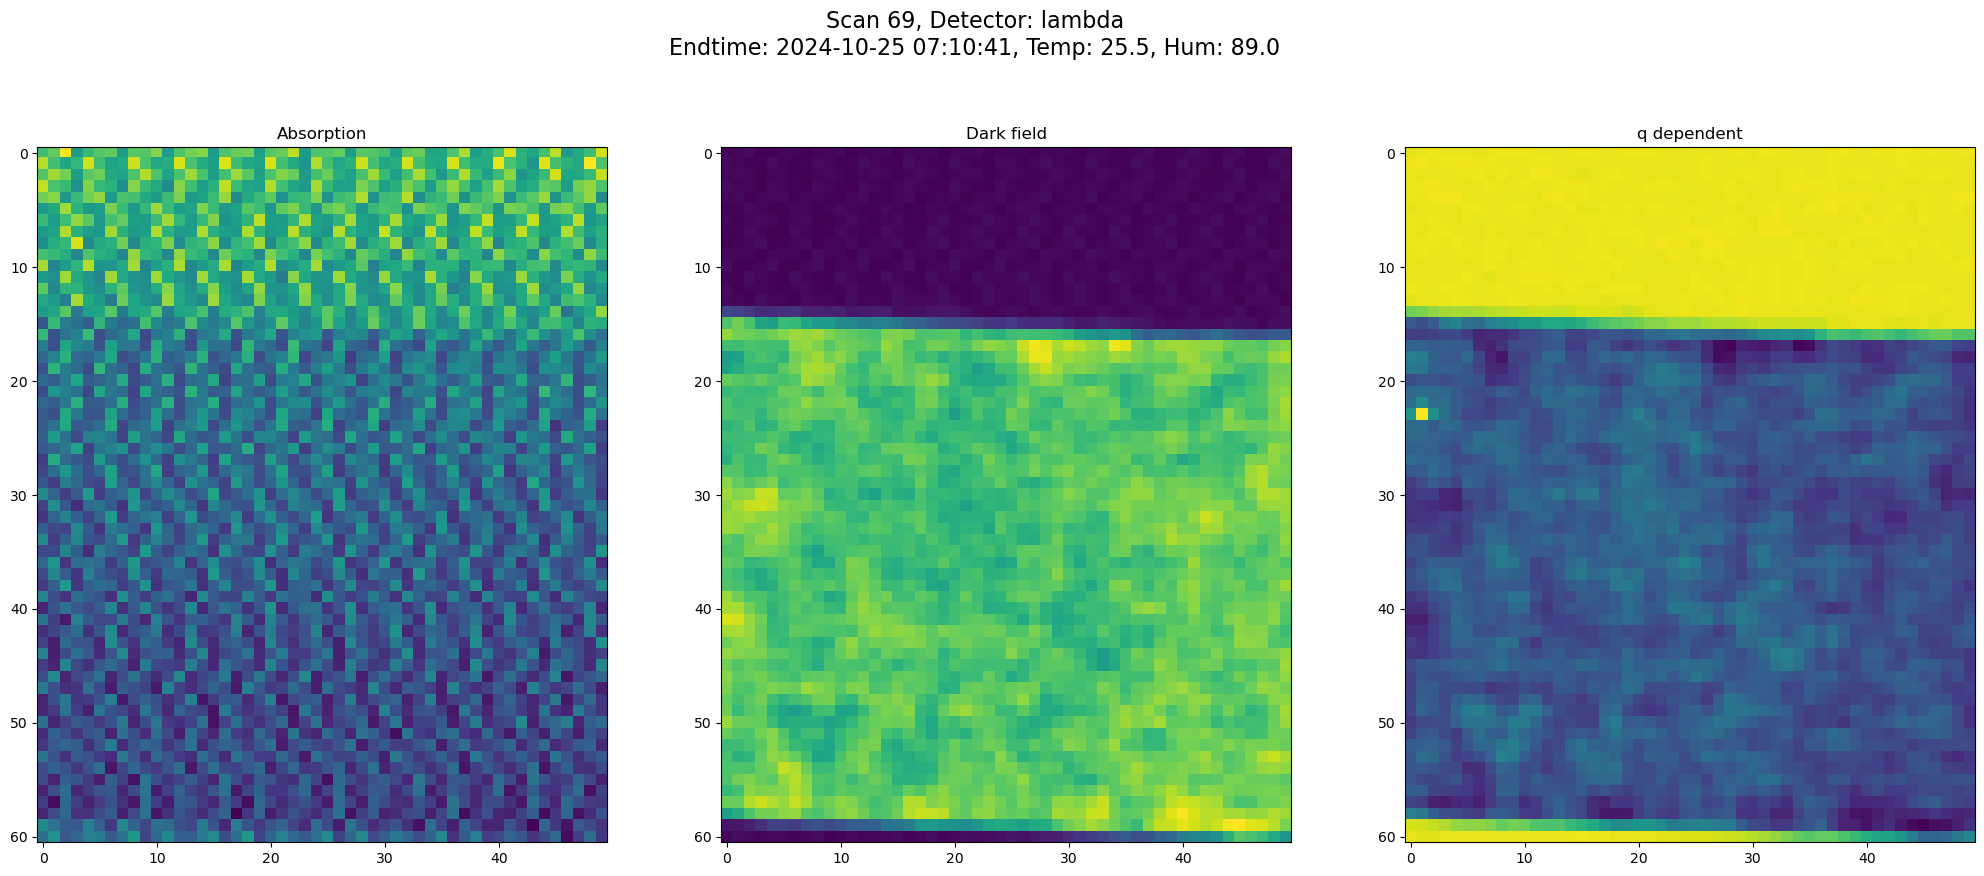

In [77]:

for i, scan in enumerate(scans):
    try:
        absorption, total_scattering, image, endtime, temp, hum = scan_data[i]
        print('plotting scan %d' %scan)
        text = 'Endtime: %s, Temp: %.1f, Hum: %.1f' %(endtime.strftime('%Y-%m-%d %H:%M:%S'), temp, hum)
        print(text)
        plot_data(scan, proposal, visit, det, absorption, total_scattering, image, text)
    except:
        print('Failed to plot scan %d' %scan)
        continue

    




# Orientation analysis

### Data processing

In [10]:
!pip install pyestimate

(1, 135)
(3050, 180)
52.45246079257915
0.22051519273649356
-2.696608469513097


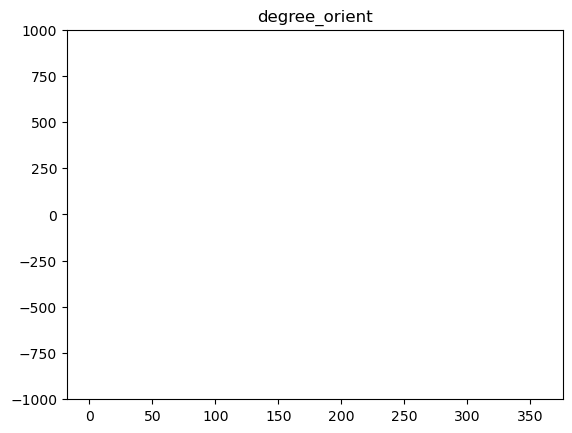

In [13]:

from pyestimate import sin_param_estimate

#Defining angular range for background fitting (to subtract gaps) 
ind_ang = np.array([np.arange(0,26)])


ind_ang1 = np.array([np.arange(0,26)])
ind_ang2 = np.array([np.arange(66,113)])
ind_ang3 = np.array([np.arange(118,180)])

ind_ang = np.concatenate((ind_ang1,ind_ang2),axis=1)
ind_ang = np.concatenate((ind_ang,ind_ang3),axis=1)
print(ind_ang.shape)

#Background subtraction and cropping
data_azi = np.sum(data_scat[:,:,:,ind_q],axis=3) - 0.5*((len(ind_q)/len(ind_bg1))*np.sum(data_scat[:,:,:,ind_bg1],axis=3)+(len(ind_q)/len(ind_bg2))*np.sum(data_scat[:,:,:,ind_bg2],axis=3)) 
data_azi = np.vstack(data_azi)
print(data_azi.shape)




#A,f,phi = sin_param_estimate(data_azi[1000,:])
A,f,phi = sin_param_estimate(data_azi[3000,:])
#A,f,phi = sin_param_estimate(data_azi[5205,:])
#A,f,phi = sin_param_estimate(data_azi[5314,:])

print(A)
print(f)
print(phi)


plt.figure()
#plt.plot(data_azi[1000,:])
#plt.plot(2*ind_ang, data_azi[5205, ind_ang])
plt.plot(2*ind_ang, data_azi[3000, ind_ang])
#plt.plot(data_azi[5314,:])
#plt.plot(A*np.cos(2*np.pi*n*f+phi), 'r--')
plt.title('degree_orient')
plt.ylim([-1000,1000])
plt.show()


